In [1]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,naive_bayes,preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
stemmer = PorterStemmer()
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
mypca = PCA(0.9)
lda = LinearDiscriminantAnalysis(n_components=2)

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Negative":
            y.values[i]=0.0
        elif y[i]=="Positive":
            y.values[i]=1.0
        else:
            y.values[i]=2.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

def select_n_components(ratio, goal):
        # Set initial variance explained so far
        s=0.0 
        # Set initial number of features
        num_components = 0

        for i in ratio:
            s += i
            num_components += 1
            if s >= goal:
                break

        # Return the number of components
        return num_components

In [4]:
with open("All_Tickers.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")
print("Number of Examples : ",len(X))
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")
X.to_csv (r'General.csv', index = False, header=True)

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())

y=target_arrange(X['Target'])

print("\n")
print("Negative Examples : ",(y==0.0).sum())
print("Positive Examples : ",(y==1.0).sum())
print("Neutral Examples : ", (y==2.0).sum())





Number of Examples :  28680
Number of Examples after removing duplicates:  28478 

Number of words before cleaning :  1086021
Number of words after cleaning :  730700


Negative Examples :  3262
Positive Examples :  10112
Neutral Examples :  15104


In [5]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])

print(X['Article'])

0        vianet group inc announc unaudit second quarte...
1        krato present canaccord virtual growth confer ...
2        rewalk robot report second quarter financi res...
3        pyxi tanker announc date releas second quarter...
4        bionano genom report second quarter financi re...
                               ...                        
28473    latest market buzz market go crazi spac reader...
28474    hubspot surg august digit market softwar compa...
28475    dividend increas expect septemb august anoth e...
28476    jcom final deadlin rosen trust top rank law fi...
28477    virgin galact plan next test spaceflight oct n...
Name: Article, Length: 28478, dtype: object


In [6]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9)
Xv = tfidf_vectorizer.fit_transform(X['Article'])
Xv = pd.DataFrame(Xv.todense())
X_train,X_test,y_train,y_test = train_test_split(Xv,y, test_size=0.25,stratify=y)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = mypca.fit_transform(X_train)
X_test = mypca.transform(X_test)

X_lda = lda.fit(X_train, y_train)

X_train=lda.transform(X_train)
X_test=lda.transform(X_test)


{'C': 10, 'gamma': 1e-06, 'kernel': 'rbf'}

Metrics

 Recall metric: 0.7737167584798348
 F1 metric: 0.7632507357630849
 Precision metric: 0.7563142064607701
 Accuracy metric: 0.7985955056179775
 Balanced Accuracy metric: 0.7737167584798348 

**************************************************

Normalized confusion matrix
[[0.69 0.22 0.08]
 [0.06 0.82 0.12]
 [0.04 0.15 0.81]]


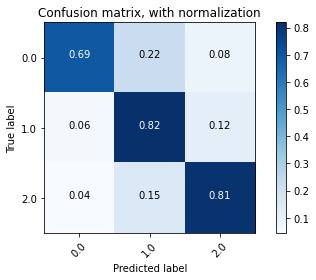

In [7]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [
  {'C': [0.03, 0.1, 1, 10, 100 ], 'gamma': [5, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 'kernel': ['rbf']},
  
 ]

grid = GridSearchCV(SVC(class_weight='balanced', decision_function_shape='ovo'), tuned_parameters, n_jobs=-1, refit = True, cv=5) 
grid.fit(X_train, y_train) 
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 

print("\nMetrics\n")
recall = metrics.recall_score(y_test,grid_predictions ,average='macro')
precision = metrics.precision_score(y_test,grid_predictions ,average='macro')
f1 = metrics.f1_score(y_test,grid_predictions ,average='macro')
Accur=metrics.accuracy_score(y_test,grid_predictions )
B_Accur=metrics.balanced_accuracy_score(y_test,grid_predictions )

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, grid_predictions ,labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0, 2.0],
                      title='Confusion matrix, with normalization')